In [2]:
# EXTRACT TILES
import torch
import os
import slideflow as sf
import torch
from src.subpatch import extract_tiles


data_path = 'data/med_examples'
file_path = 'med_sample1.tiff'
tfr = extract_tiles(file_path, data_path)
print(len(tfr))

1027


In [3]:
# EXTRACT FEATURES
from src.model import UNI2FeatureExtractor

batch_size = 32
patch_size = 224
subpatch_size = 14
emb_dim = 1536

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
extractor = UNI2FeatureExtractor(
    batch_size=batch_size,
    patch_size=patch_size,
    subpatch_size=subpatch_size,
    emb_dim=emb_dim, 
    device=device
)
num_patches = len(tfr) + 1
subpatches_in_patch = (extractor.patch_size // extractor.subpatch_size) ** 2
# filename_noext = os.path.splitext(os.path.basename(file_path))[0]
subpatch_features, images, locx, locy, maxx, maxy = extractor.get_subpatch_features(tfr)

print(f"Num subpatches: {num_patches * subpatches_in_patch}, Image size: {maxx, maxy}, Patch size: {patch_size}, Batch size: {batch_size}")


/home/jakub/miniconda3/envs/CPATH/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Num subpatches: 263168, Image size: (8064, 10752), Patch size: 224, Batch size: 32


In [4]:
# CLUSTER SUBPATCHES
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output
from src.utils import create_image


def display_legend(tint_map):
    legend_height = 10 * len(tint_map)
    legend_width = 30
    legend_img = np.ones((legend_height, legend_width, 3), dtype=np.float32)
    cwidth = 10

    for i, (cluster_id, color) in enumerate(tint_map.items()):
        y0 = i * 10
        legend_img[y0 : y0 + cwidth, 2:cwidth] = color  # color rectangle

    fig = plt.gcf()
    newax = fig.add_axes([0.82, 0.80, 0.06, 0.06], anchor="NE", zorder=10)
    newax.imshow(legend_img)
    newax.axis("off")
    
    for i, (cluster_id, color) in enumerate(tint_map.items()):
        y0 = i * 10
        newax.text(
            cwidth + 2,
            y0 + 6,
            f"Cluster {cluster_id}",
            va="center",
            fontsize=9,
            color="black",
        )

def display_image(
    cluster_ids, 
    images, 
    locx, 
    locy, 
    maxx, 
    maxy, 
    patch_size, 
    subpatch_size,
    ):
    clear_output(wait=True)

    final_image, tint_map = create_image(
        cluster_ids=cluster_ids,
        maxx=maxx,
        maxy=maxy,
        locx=locx,
        locy=locy,
        images=images,
        patch_size=patch_size,
        subpatch_size=subpatch_size,
        subpatches_in_patch=subpatches_in_patch
    )

    columns = maxx // subpatch_size + 1
    rows = maxy // subpatch_size + 1
    plt.figure(1, figsize=(columns // 32, rows // 32), frameon=False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(final_image)
    sorted_tint_map = dict(sorted(tint_map.items()))
    display_legend(sorted_tint_map)

    plt.savefig('segmentation.png')
    plt.show(block=False)

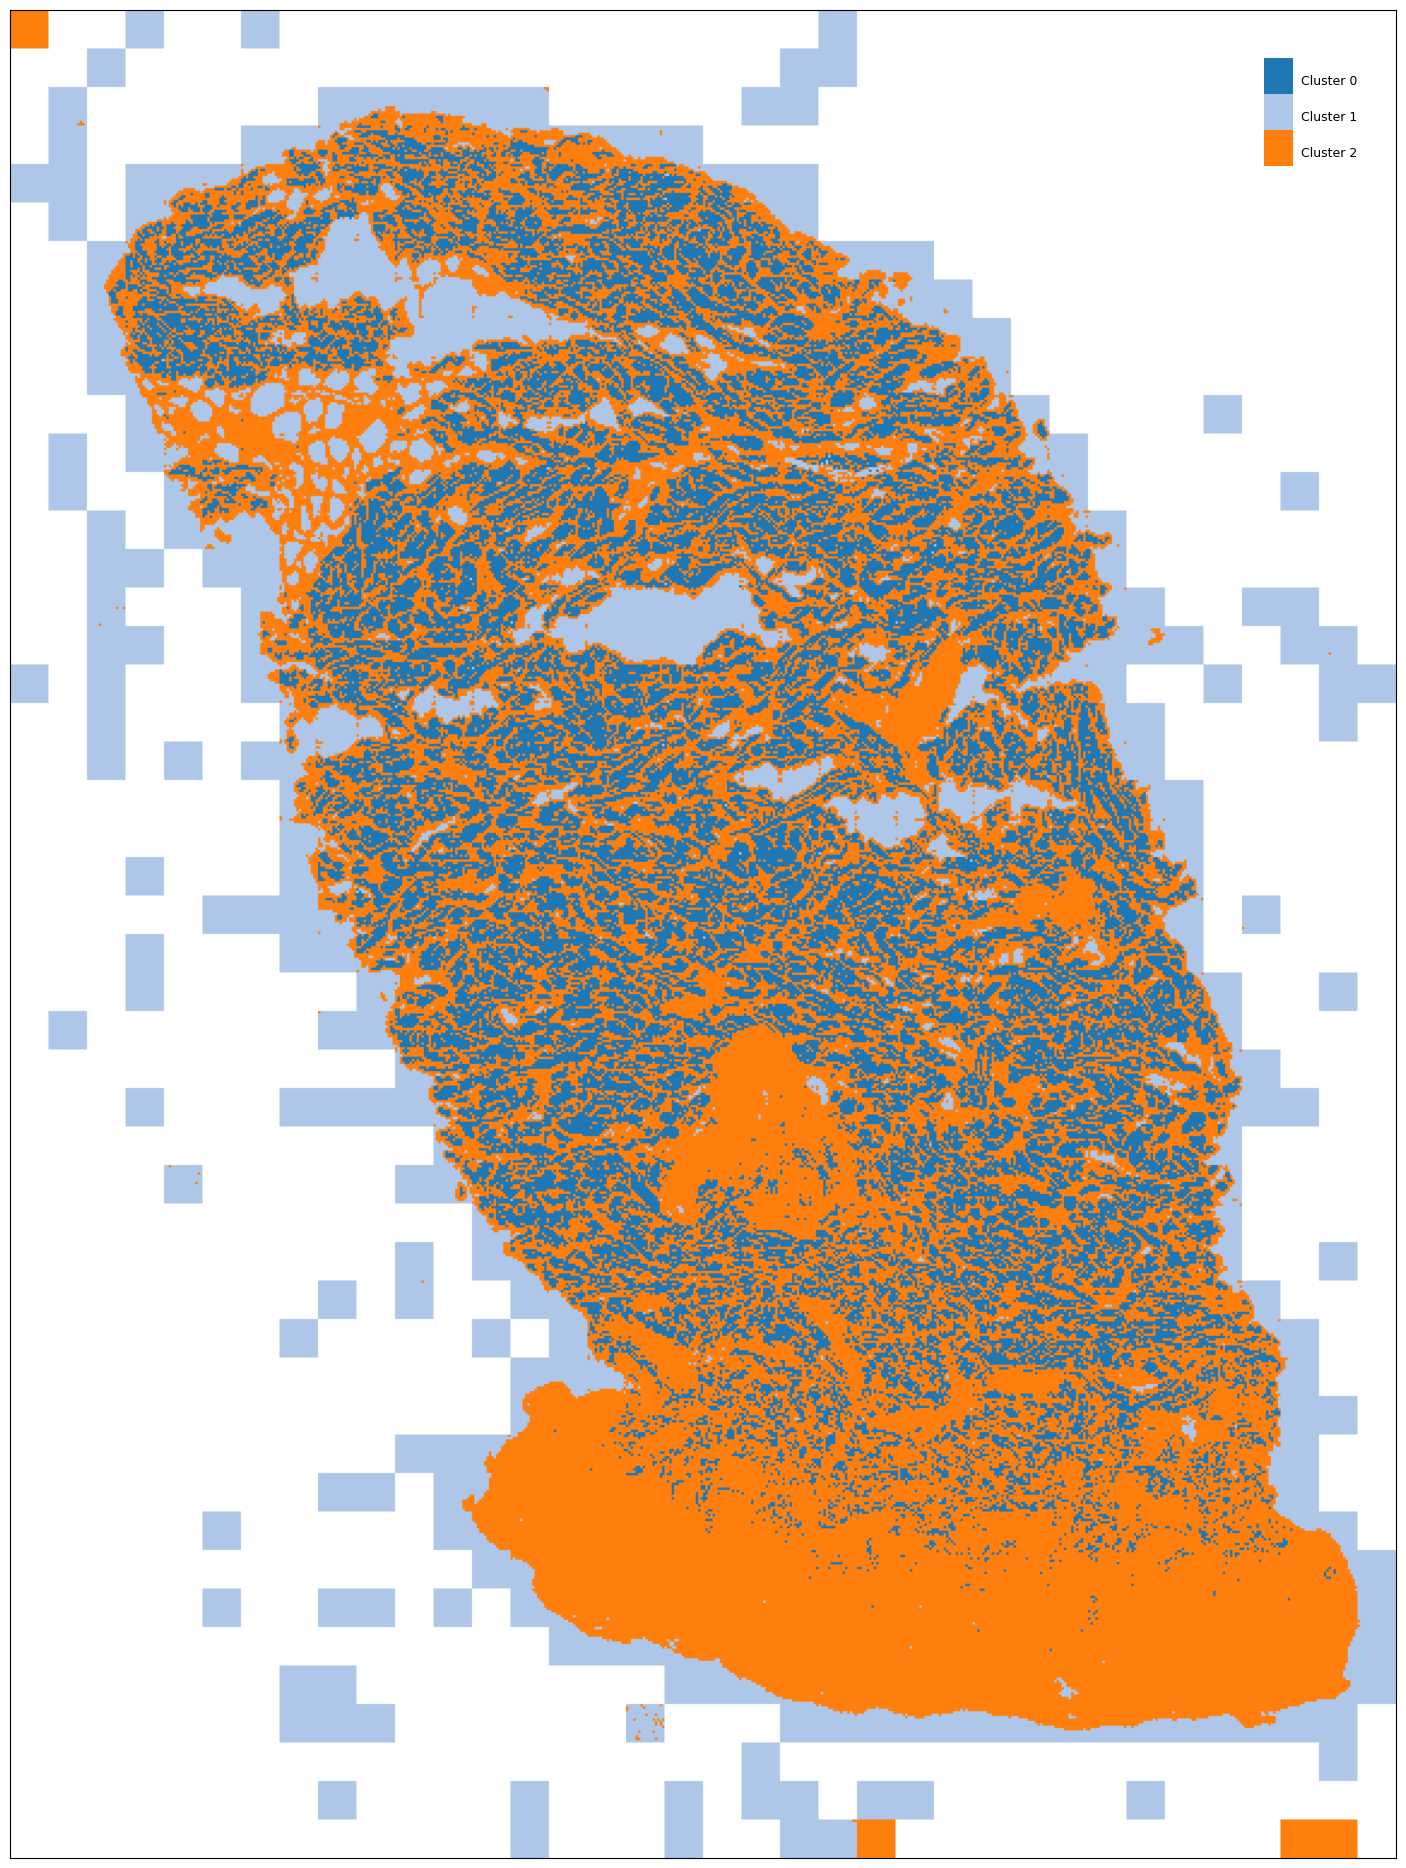

In [5]:
import numpy as np

from kmeans_pytorch import kmeans
from src.model import ClusterSegmentationModel
from src.subpatch import calculate_cluster_centers, calculate_cluster_ids


np.random.seed(6)

num_clusters = 2
features = subpatch_features + 1e-9
feature_dim = features.shape[-1]
features = features.view(-1, feature_dim)
cluster_ids, cluster_centers = kmeans(
    X=features, 
    num_clusters=num_clusters, 
    distance='euclidean', 
    device=features.device,
)
features = features.view(-1, subpatches_in_patch, feature_dim)
# Ideas:
# 1. Train RL agent to interact with the guided clustering
# 2. Calculate representatives of the clusters and use VLMs to give them names
# 3. Extract prototypes of the clusters and use them to cluster other images
# 4. Create a confidence score for each slide which is a sum of the distances to the cluster centroids
while True:
    display_image(
        cluster_ids=cluster_ids,
        images=images,
        locx=locx,
        locy=locy,
        maxx=maxx,
        maxy=maxy,
        patch_size=patch_size,
        subpatch_size=subpatch_size,
    )

    cluster_to_expand = input(
        "Enter cluster number to expand (or 'q' to quit): "
    )

    if cluster_to_expand.lower() == 'q' or len(cluster_to_expand) == 0:
        break

    try:
        cluster_to_expand = int(cluster_to_expand)
    except ValueError:
        print("Invalid input. Please enter a valid cluster number or 'exit'.")
        continue

    chosen_cluster_mask = (cluster_ids == cluster_to_expand)
    
    if not chosen_cluster_mask.any():
        print(f"Cluster {cluster_to_expand} not found.")
        continue

    features_flat = features.view(-1, feature_dim)
    features_to_cluster = features_flat[chosen_cluster_mask]
    new_cluster_ids, _ = kmeans(
        X=features_to_cluster, 
        num_clusters=num_clusters, 
        distance='euclidean', 
        device=features.device,
    )
    
    maxid = cluster_ids.max().item()
    new_cluster_ids[new_cluster_ids == 0] = cluster_to_expand - maxid
    cluster_ids[chosen_cluster_mask] = maxid + new_cluster_ids

    cluster_centers, center_ids = calculate_cluster_centers(features, cluster_ids)
    cluster_ids = calculate_cluster_ids(features, cluster_centers, center_ids)

In [8]:
cluster_centers, center_ids = calculate_cluster_centers(features, cluster_ids)

segmentation_model_save_path = "models/test_model.pth"
segmentation_model = ClusterSegmentationModel(cluster_centers=cluster_centers, center_ids=center_ids)
segmentation_model.save(segmentation_model_save_path)
segmentation_model = ClusterSegmentationModel.load(segmentation_model_save_path)

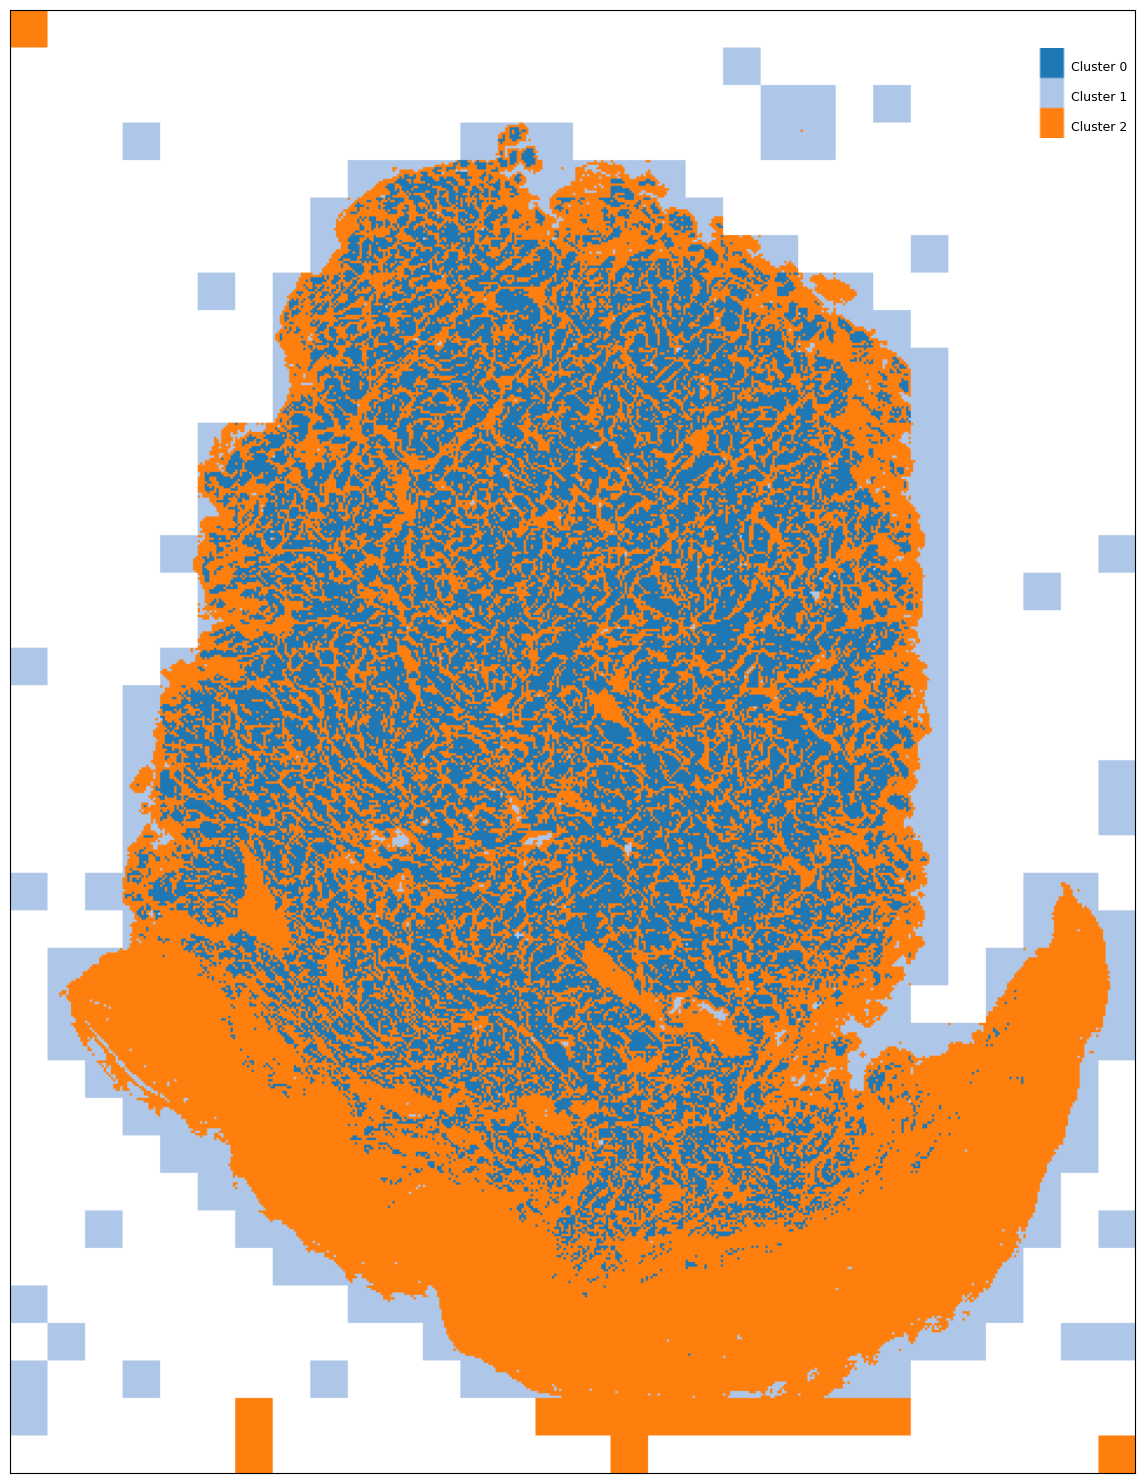

In [11]:
file_path = 'med_sample2.tiff'

tfr = extract_tiles(file_path, data_path)
subpatch_features, images, locx, locy, maxx, maxy = extractor.get_subpatch_features(tfr)
subpatch_features_flat = subpatch_features.view(-1, segmentation_model.feature_dim)
cluster_ids = segmentation_model(subpatch_features_flat)

display_image(
    cluster_ids=cluster_ids,
    images=images,
    locx=locx,
    locy=locy,
    maxx=maxx,
    maxy=maxy,
    patch_size=patch_size,
    subpatch_size=subpatch_size,
)

In [ ]:
file_path = 'med_sample4.tiff'

tfr = extract_tiles(file_path, data_path)
subpatch_features, images, locx, locy, maxx, maxy = extractor.get_subpatch_features(tfr)
subpatch_features_flat = subpatch_features.view(-1, segmentation_model.feature_dim)
cluster_ids = segmentation_model(subpatch_features_flat)

display_image(
    cluster_ids=cluster_ids,
    images=images,
    locx=locx,
    locy=locy,
    maxx=maxx,
    maxy=maxy,
    patch_size=patch_size,
    subpatch_size=subpatch_size,
)

[09:13:16] INFO     No ROI for med_sample4, using whole slide.

[09:13:18] INFO     Finished tile extraction for med_sample4 (780 tiles of 780 possible)

TypeError: UNI2FeatureExtractor.get_subpatch_features() takes 2 positional arguments but 3 were given